# Assignment: Implementing K-Means Clustering from Scratch and Application on Cancer Data Set

## Objective:
The purpose of this assignment is learn about experiment with the K-Means clustering algorithm we'll talk about in class. First we'll implement it from scratch using the Python and numpy library. Following this, we'll apply your implementation to a real-world RNA-sequencing data set. 

### Problem:

### Part 1: K-Means Clustering Implementation 
1. You are asked to create a function named 'kmeans_clustering', which will implement the K-Means clustering algorithm.
2. This function should accept as input a numpy data matrix (2D array). Each row of the matrix will represent a data point and each column represents a feature of the data.
3. The function should output two things: a list of centroid coordinates and a list of cluster assignments for each data point.
4. You should implement the iterative process of the K-Means algorithm: assignment step, update step, and the convergence check. The function should stop iterating when the centroids no longer change significantly or after a preset maximum number of iterations.
5. Your function should allow the user to specify the number of clusters (k), the maximum number of iterations, and the convergence tolerance.

### Part 2: Testing K-Means on Cancer Data Set 
1. You will apply your K-Means clustering function to a real-world cancer data set.
2. Before applying the function, you should preprocess the data as needed. This may include normalizing the data, dealing with missing values, or encoding categorical variables as appropriate.
3. Interpret and discuss the results. How well does the K-Means algorithm perform? Are the clusters meaningful in the context of the cancer data set? 


# Getting started

### Import some needed packages

We'll use Pandas to load the cancer data set, numpy for basic matrix handling, and sklearn for a kmeans comparison and use of their PCA implementation. You might need to install pandas, numpy, and sklearn on your setup for this homework.

In [1]:
import pandas as pd
import numpy as np

# sklearn is a python package with many reference implementations of machine learning tools
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import adjusted_rand_score

# plotting imports for creating plots using matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]



Data set download here: [linl](https://cnls.lanl.gov/external/qbio2018/Slides/Cluster_Lab_June18/)
Write-up on analysis here: [link](https://dtp.cancer.gov/discovery_development/nci-60/)

# Lets see how k-means runs using sklearn

Here we'll steal some code from sklearn to run their implementation of k-means clustering. They have some nice code to show the clustering with the decision boundaries and the centroids plotted to see how specific points in 2D space are classified into one cluster or another that you can also explore in the links below. You should run this section to make sure you're setup works, and to ultimately compare against your implementation. 

Here are the sources for much of the sklearn and plotting code on sklearn's page: 

- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py

- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html

## Make some fake data to play around with our kmeans implementation:

In [81]:
# Make some fake data using a set random state
n_samples = 2000
n_centers = 4
random_state = 0 # use a set value here to always produce the same data set from make_blobs function

sample_dataset, sample_dataset_known_clusters, sample_dataset_known_centers = make_blobs(n_samples=n_samples, random_state=random_state, return_centers=True, centers=n_centers)


### some plotting code to see our clustering results:

In [84]:
def plot_individual_kmeans_results(plotting_axis,x,y,known_labels,centroids, title):
    plotting_axis.scatter(x, y, c=known_labels)
    plotting_axis.set_title(title)
    plotting_axis.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="r",
        zorder=10)
    
def plot_paired_kmeans(data_set, known_labels, predicted_cluster_labels, centroids):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
    
    plot_individual_kmeans_results(axs[0],data_set[:, 0],data_set[:, 1],known_labels,centroids,"Known labels")
    plot_individual_kmeans_results(axs[1],data_set[:, 0],data_set[:, 1],predicted_cluster_labels,centroids,"Predicted labels")
    
    
def plot_individual_kmeans(data_set, labels, centroids, dot_labels=None):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
    
    plot_individual_kmeans_results(axs,data_set[:, 0],data_set[:, 1],labels,centroids,"kmeans results") 
    
    if dot_labels is not None:
        for i in range(len(dot_labels)):
            axs.text(x=data_set[i, 0]+0.3,y=data_set[i, 1]+0.3, s=dot_labels[i])
    


### Lets run the sklearn version and plot the results against the ground truth

Adjusted rand index of our predictions:  0.8334979002578613


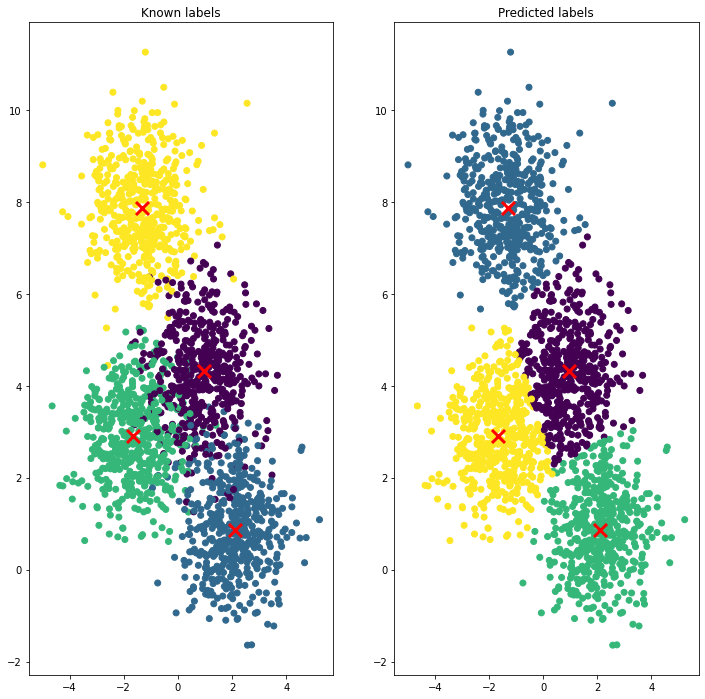

In [83]:
# setup a basic kmeans with a random starting point for the centroids
kmeans = KMeans(init="random", n_clusters=n_centers, n_init=4)

# run the standard sklearn fitting mechanism on our simulated data
kmeans.fit(sample_dataset)
predicted_cluster_labels = kmeans.fit_predict(sample_dataset)

# Obtain labels for each point. Use our kmeans clustering results above
predicted_centroids = kmeans.cluster_centers_

plot_paired_kmeans(sample_dataset, sample_dataset_known_clusters, predicted_cluster_labels, predicted_centroids)
# we need to use a method to measure accurancy that isn't sensitive to the label 'names', but instead looks
# at how concordant the two classification labels are regardless of their actual names; i.e. the 2s in one
# classification might correspond to the 1s in another kmeans run. the adjusted rand score (ARI) does this for us:
print("Adjusted rand index of our predictions: ",adjusted_rand_score(sample_dataset_known_clusters,predicted_cluster_labels))


## Distance computation 

Lets break down what we'll need to have for Lloyd's algorithm:

- A way to find the distances from each point to each centroid
- A way to find the best centroid for each point
- A way to update the centroids from the mean of their clustered points

Let's see how we'd implement our distance to centers function, testing it with the following example:

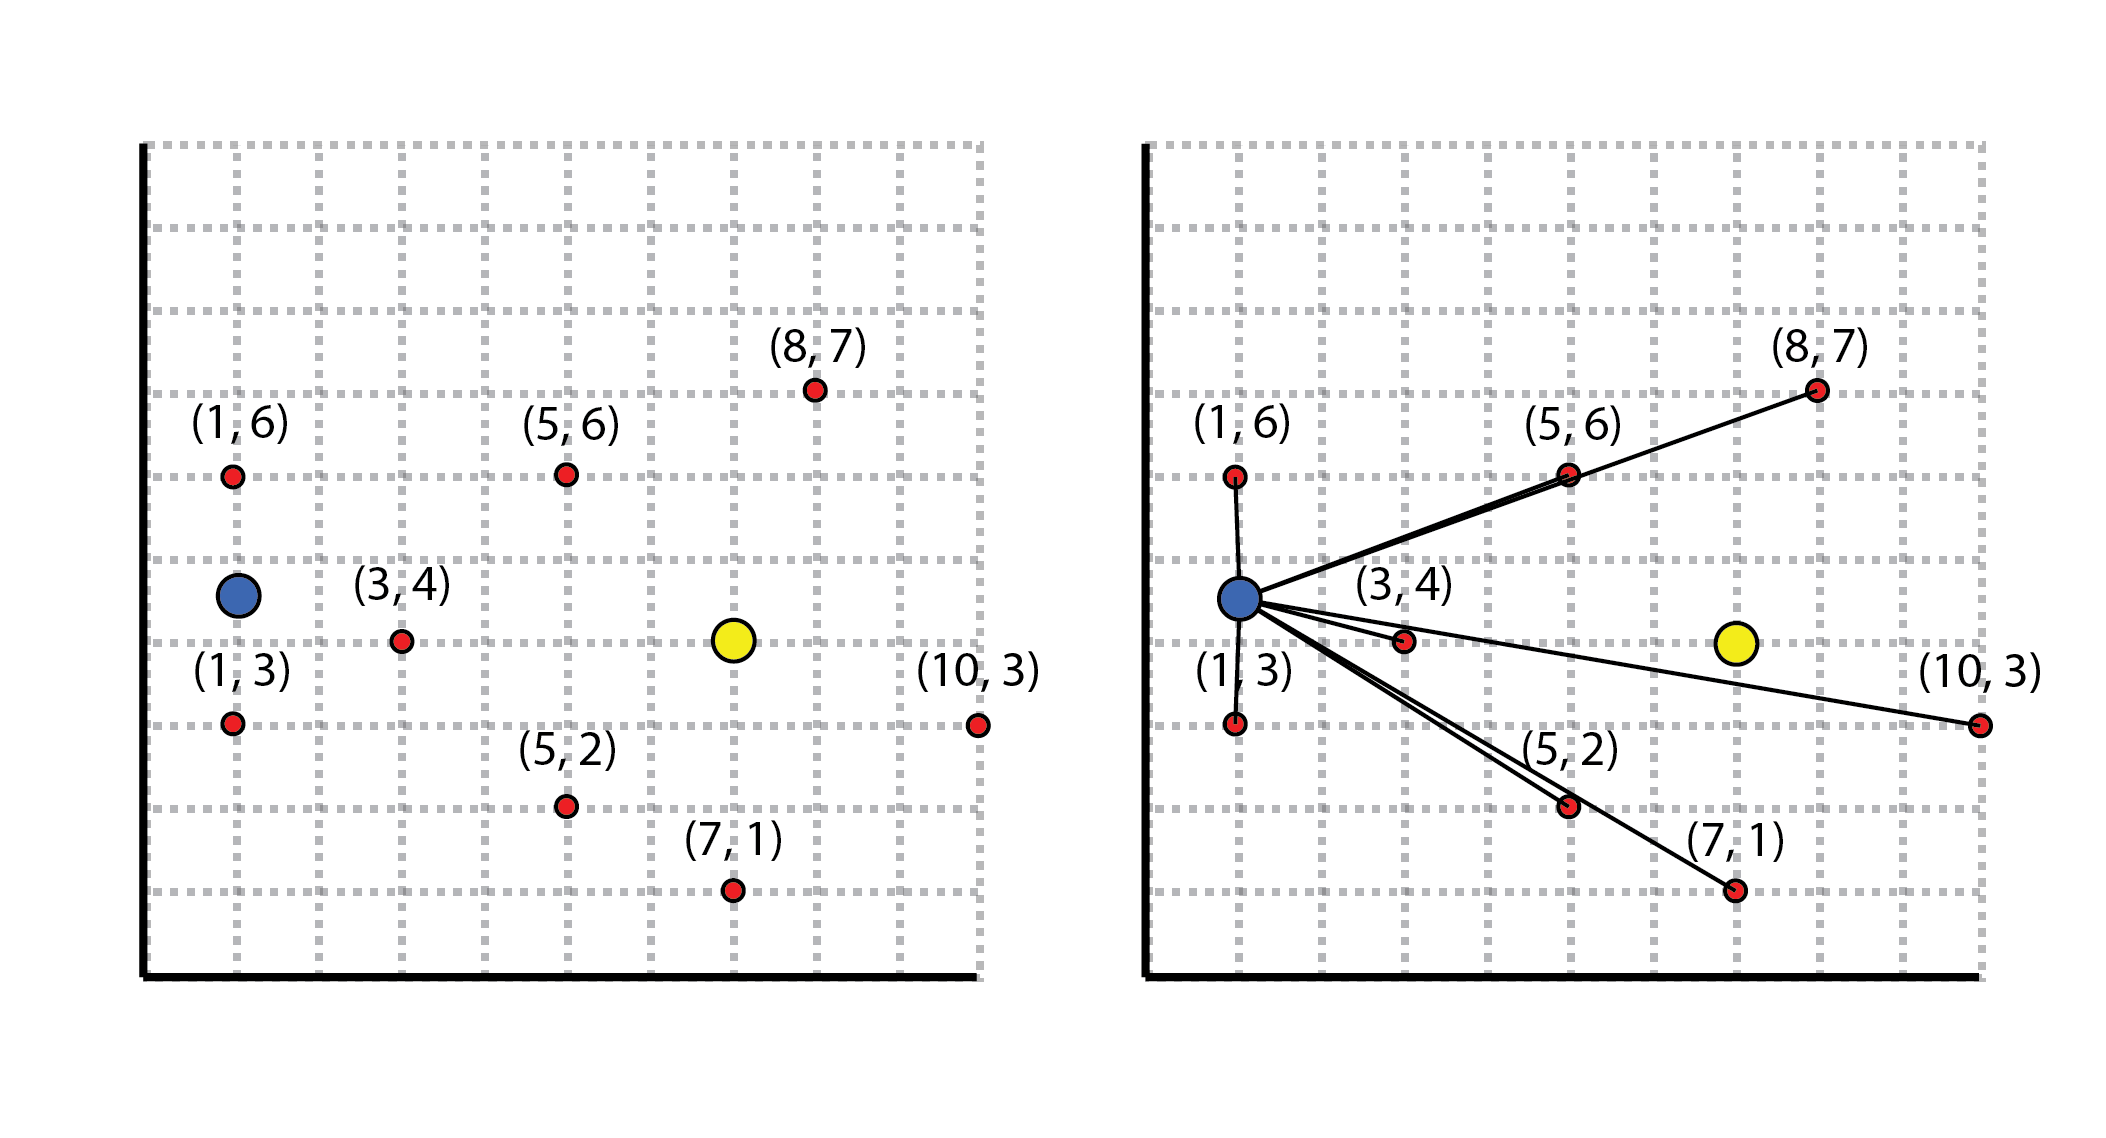

The function will return a matrix with the distances from each point (row) to each centroid (column). In the 
diagram on the right I'm showing those distance calculations for the blue centroid, the yellow dot will be the second column:

In [5]:
def distance_to_centers(centroids, datapoints):
    """
    Calculates the distances between a set of centroids and a set of datapoints.

    Parameters:
        centroids (numpy.ndarray): An array representing the centroids.
        datapoints (numpy.ndarray): An array representing the datapoints.

    Returns:
        numpy.ndarray: An array of distances between each datapoint and each centroid.
    """
    distances = np.linalg.norm(datapoints[:, np.newaxis, :] - centroids, axis=2)
    return(distances)

datapoints = np.array([[1, 6],[1,3],[3,4],[5,6],[8,7],[10,3],[5,2],[7,1]])
centroids = np.array([[1,4.5],[7,4]])

distance_to_centers(centroids,datapoints)

array([[1.5       , 6.32455532],
       [1.5       , 6.08276253],
       [2.06155281, 4.        ],
       [4.27200187, 2.82842712],
       [7.43303437, 3.16227766],
       [9.1241438 , 3.16227766],
       [4.71699057, 2.82842712],
       [6.94622199, 3.        ]])

#### One step 

This is one step in the algorithm below (you'll call it from your function). Try to work through the rest!

### Your k-means implementation

The Rand index above shows a really nice classification effort from the default k-means implementation. You can see by eye where the boundaries of k-means classifies the points generated from one distribution into another cluster, but overall the results are very clean.

#### Your implementation

We'll be implmenting the [Lloyd's algorithm](https://en.wikipedia.org/wiki/K-means_clustering) as our approach to the naive k-means clustering. We'll initialize our Llyods algorithm using random data points selected from the input data set, like we show in the class slides. We'll then iterate, finding the distances to the centroids for each point, finding the closest centroid for each point, and moving centroids to the mean all their assigned data points. We do this until either the centroids haven't moved (or moved less than some small value) or we hit the maximum iteration count (max_iters).

To implement the kmeans clustering you'll need to take in:
- A dataset, this will be ```m * 2```, where ```m``` is the number of samples, each of which has two data points. 
- k, the number of clusters
- A maximum number of iterations to run

You'll need to return two numpy arrays, one containing the 2D locations of the centroids of your clusters (```k x 2```), and a second list containing the cluster assignments for each m (sized ```m```). 

In [4]:
import numpy as np

def kmeans_clustering(data_set, k, max_iters=1000):
    """
    Perform k-means clustering on the input data X.

    Arguments:
    X -- A numpy array of shape (m, n) where each row is a data point and n = 2
    k -- The number of clusters to form.
    max_iters -- The maximum number of iterations to run the algorithm.

    Returns:
    centroids -- A numpy array of shape (k, n) containing the final centroids of the clusters.
    labels -- A numpy array of shape (m) containing the index of the cluster each data point belongs to.
    
    Hints:
    the function 'np.linalg.norm' in numpy can be used to calculate the L2 norm, which is a quick
    way to find the distances between points and each centroid. Check out this page for a description:
    https://sparrow.dev/pairwise-distance-in-numpy/. You'd want to replace the subtracted term with
    the location of your centroids to get a distance to each centroid from each point, using axis=2. You
    can them use this with the np.argmin function to find the minimum distance for each m to the best
    centroid.
    
    I've left in commented steps in the process layed-out below to help guide your code.
    """
    
    m, n = data_set.shape
    assert n == 2, "The input data set needs to be a matrix of m samples by 2 dimensions"
    
    # Initialize centroids randomly among the sample space using k points
    
    # Initialize labels to -1 to indicate that no cluster has been assigned yet
    
    # Iterate until convergence or max_iters is reached:
    # - Assign each data point to the nearest centroid
    # - Check if the labels have changed -- if not we're done!
    # - Update labels and centroids
    
    return centroids, labels

your_predicted_centroids, your_predicted_labels = kmeans_clustering(sample_dataset,4)


### Let's compare your results to the known values like we did with the sklearn package

Adjusted rand index of our predictions:  0.8323238102251581


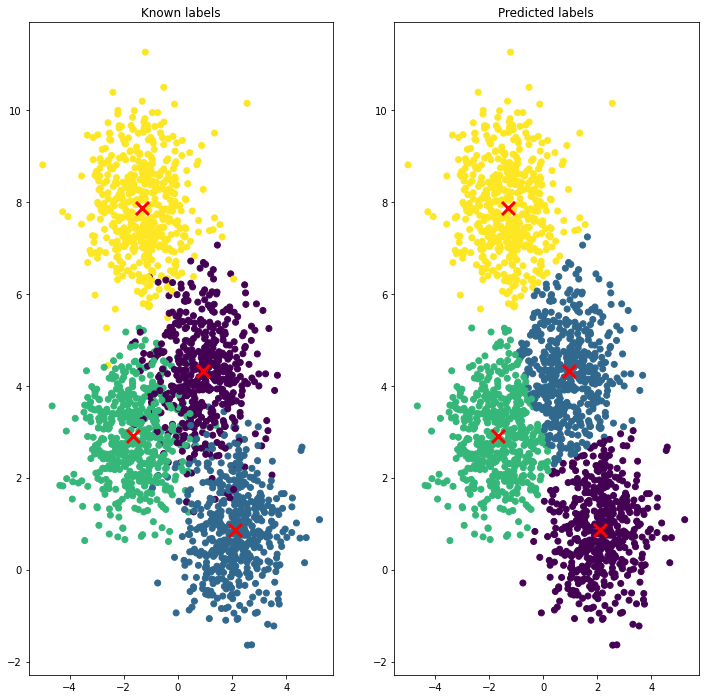

In [88]:

plot_paired_kmeans(sample_dataset, sample_dataset_known_clusters, your_predicted_labels, your_predicted_centroids)

# we need to use a method to measure accurancy that isn't sensitive to the label 'names', but instead looks
# at how concordant the two classification labels are regardless of their actual names; i.e. the 2s in one
# classification might correspond to the 1s in another kmeans run. the adjusted rand score (ARI) does this for us:
print("Adjusted rand index of our predictions: ",adjusted_rand_score(sample_dataset_known_clusters,your_predicted_labels))



# Clustering RNA-sequencing data with k-means

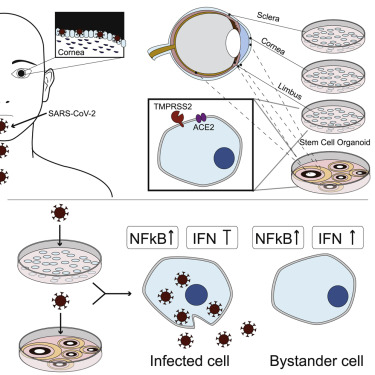

Above is the graphical abstract from [Eriksen et al.](https://www.sciencedirect.com/science/article/pii/S1934590921001867?via%3Dihub) This paper look at celular changes in post mortem tissues taken from regions of the eye, of COVID-positive patients, and compared these samples to controls. Their goal was to understand how likely cells of the eye are to be infected with the COVID virus and to explore the molecular changes this infection brings. The data is available here:

- [NCBI GEO link](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE164073)



#### First we need to load the expression matrix

We've downloaded the preprocessed expression data for you. The file ```covid_eye_filtered.tsv.gz``` should be available in the github repository. Let's load it up with Pandas:

In [105]:
covid_vs_mock = pd.read_csv('eye_counts.csv.gz',index_col=0)
print(covid_vs_mock.shape)

# Lets look at the first/last few rows...
covid_vs_mock


(27946, 18)


MW1_cornea_mock_1  MW2_cornea_mock_2  MW3_cornea_mock_3  \
Gene                                                                
A1BG                     91                131                 86   
A1BG-AS1                292                284                271   
A1CF                      0                  0                  0   
A2M                     255                273                263   
A2M-AS1                   8                  9                  9   
...                     ...                ...                ...   
ZYG11A                   23                 28                 35   
ZYG11B                 1091               1364               1302   
ZYX                    6320               6309               5493   
ZZEF1                  1310               1361               1541   
ZZZ3                   1197               1407               1356   

          MW4_cornea_CoV2_1  MW5_cornea_CoV2_2  MW6_cornea_CoV2_3  \
Gene                                                                
A1BG                     77                 69                 72   
A1BG-AS1                232                250                241   
A1CF                      0                  0                  0   
A2M                     150                176                179   
A2M-AS1                  11                 16                  8   
...                     ...                ...                ...   
ZYG11A                   11                 13                 19   
ZYG11B                 1246               1443               1072   
ZYX                    5023               6000               5514   
ZZEF1                  1415               1844               1340   
ZZZ3                   1312               1385               1114   

          MW7_limbus_mock_1  MW8_limbus_mock_2  MW9_limbus_mock_3  \
Gene                                                                
A1BG                    128                 97                112   
A1BG-AS1                444                311                355   
A1CF                      0                  0                  0   
A2M                     430                154                254   
A2M-AS1                  13                 12                  7   
...                     ...                ...                ...   
ZYG11A                   25                 35                 21   
ZYG11B                 1455               1879               1697   
ZYX                    9138               8254               7659   
ZZEF1                  1161               1531               1341   
ZZZ3                   1175               1143               1070   

          MW10_limbus_CoV2_1  MW11_limbus_CoV2_2  MW12_limbus_CoV2_3  \
Gene                                                                   
A1BG                      96                  95                  82   
A1BG-AS1                 274                 298                 322   
A1CF                       0                   0                   0   
A2M                      162                 146                 214   
A2M-AS1                   13                  12                  12   
...                      ...                 ...                 ...   
ZYG11A                    15                  20                  33   
ZYG11B                  1260                1332                1771   
ZYX                     5776                5434                6423   
ZZEF1                   1050                1176                1573   
ZZZ3                     948                 852                1174   

          MW13_sclera_mock_1  MW14_sclera_mock_2  MW15_sclera_mock_3  \
Gene                                                                   
A1BG                      82                  70                 101   
A1BG-AS1                 233                 241                 243   
A1CF                       0                   0                   0   
A2M                

### Reduce the dimensions

We have a (28307, 18) matrix, which is a bit too much for our kmeans clustering to handle (and for us to interpret). Our first step will be to reduce the dimensions using principal components analysis (PCA) to a more reasonable 18x2 matrix that hopefully captures most of the variance from the original data.

In [106]:
pca_components = 2
reduced_data = PCA(n_components=pca_components).fit_transform(covid_vs_mock.values.transpose())

### Now let's try using the sklearn k-means clustering

We'll use a little function that computes the average Rand score over X trials of kmeans to smooth out the average a bit

In [ ]:

def average_kmeans(my_reduced_data,my_covid_vs_mock, k, iterations=100):
    rand_index_scores = []
    for i in range(iterations):
        kmeans = KMeans(init="random", n_clusters=k)

        # run the standard sklearn fitting mechanism on our simulated data
        kmeans.fit(my_reduced_data)
        predicted_cluster_labels = kmeans.fit_predict(my_reduced_data)

        # Obtain labels for each point. Use our kmeans clustering results above
        predicted_centroids = kmeans.cluster_centers_

        full_samples = list(my_covid_vs_mock.columns)
        tissues = [x.split("_")[1] for x in full_samples]
        is_mock = [x.split("_")[2] == 'mock' for x in full_samples]
        sample_assignments = pd.DataFrame({'predicted_cluster': predicted_cluster_labels, 
                                            "tissue": tissues, 
                                            "is_mock": is_mock}, 
                                          index =list(covid_vs_mock.columns))
    
        # uncomment if you'd like to see some of the assignments
        #print(sample_assignments)
    
        rand_index_scores.append(adjusted_rand_score(sample_assignments['predicted_cluster'],sample_assignments['tissue']))
    return(sum(rand_index_scores)/float(iterations))

# print out our average Rand index score
average_kmeans(reduced_data,covid_vs_mock, 3)


### Improving our classification 

One thing we've completely left out is some way to normalize our data. Lets try implementing the TPM approach to transcript normalization. We've filtered our gene expression profile to only genes with well annotated gene lengths in the hg19 build of the human reference. You'll also need the gene lengths, which we've calculated and put in a matrix that should be in the same order as your genes in the expression matrix:

In [110]:
covid_vs_mock_filtered = pd.read_csv('covid_eye_filtered.tsv.gz',index_col=0,sep='\t')

gene_sizes = pd.read_csv('gene_lengths.tsv.gz',index_col=0,sep='\t')
gene_sizes

ensembl_gene_id  start_position  end_position    size
hgnc_symbol                                                       
A1BG         ENSG00000121410        58345178      58353492    8314
A1BG-AS1     ENSG00000268895        58347718      58355455    7737
A1CF         ENSG00000148584        50799409      50885675   86266
A2M          ENSG00000175899         9067664       9116229   48565
A2M-AS1      ENSG00000245105         9065163       9068689    3526
...                      ...             ...           ...     ...
ZYG11B       ENSG00000162378        52726453      52827336  100883
ZYX          ENSG00000285443       143381295     143391111    9816
ZYX          ENSG00000159840       143381295     143391111    9816
ZZEF1        ENSG00000074755         4004445       4143030  138585
ZZZ3         ENSG00000036549        77562416      77683419  121003

[28307 rows x 4 columns]

# TPM normalization (3 points)

Now we'll need to write a function to compute the transcripts per million (TPM). TPM was first described in [Wagner et al. 2012](https://link.springer.com/article/10.1007/s12064-012-0162-3), though the concept was developed by a number groups. The calculation is best described by this equation:

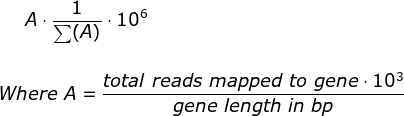
[From this Biostars post](https://www.biostars.org/p/273537/). 

The idea is that we're finding the reads-per-gene (or transcript), dividing by the length of that transcript in kilobases, and then normalizing to what proportion of a millon reads this gene's expression would represent. 

In [ ]:

def TPM_normalization(gene_counts, gene_lengths):
    """
    Performs Transcripts Per Million (TPM) normalization on gene expression data.

    TPM normalization is a method used in RNA-seq data analysis for normalizing 
    gene expression data. It accounts for both gene length and sequencing depth, 
    allowing comparison of gene expression levels between samples.

    Parameters
    ----------
    gene_counts : list of int
        The raw read counts for each gene. Each element of the list represents the 
        count of a particular gene.

    gene_lengths : list of int
        The length of each gene in base pairs. Each element of the list represents 
        the length of a corresponding gene from the gene_counts list.

    Returns
    -------
    TPM : numpy array
        The Transcripts Per Million (TPM) normalized expression values for each gene.

    Example
    -------
    >>> gene_counts = [100, 200, 300, 400, 500]
    >>> gene_lengths = [1000, 2000, 3000, 4000, 5000]
    >>> TPM_values = TPM_normalization(gene_counts, gene_lengths)
    >>> print(TPM_values)
    """
      
    # your code here
    return TPM

covid_vs_mock_tpm = covid_vs_mock_filtered.apply(TPM_normalization, gene_lengths=gene_sizes['size'], axis=0)
covid_vs_mock_tpm.shape


## Lastly lets see if this improves the our ability to cluster tissues together 

In [ ]:
reduced_data_filtered = PCA(n_components=pca_components).fit_transform(covid_vs_mock_tpm.values.transpose())

# print out our average Rand index score
average_kmeans(reduced_data_filtered,covid_vs_mock_filtered, 3)


#### Bonus point (1)

It appears that TPM calculations really saved our clustering... but it's actually only partially true. What else is a dominant factor in our improved clustering? Don't worry if you can't figure it out, but it's classic data science.